# Machine Learning estimation for std properties

Based on the Molar Mass, State of Matter, and Charge, we now create machine learning models to predict the standard free Gibbs energy of formation, enthalpy, entropy, and heat capacities.

## Required dependencies

In [1]:
import multiprocessing as mp
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm.auto import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import Callback, EpochScoring

from pathlib import Path
import os

DATA_PATH = Path(os.environ.get("DATAPATH"))
sklearn.set_config(transform_output="pandas")

pio.renderers.default = "png"

Check if PyTorch can use CUDA:

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

## Read preprocessed data

### Loading

In [3]:
df_nist_stdprops = pd.read_csv(DATA_PATH / "NBS_Tables_preprocessed.csv", index_col=0)

df_nist_stdprops

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0
...,...,...,...,...,...,...,...,...
1515,CsBO2,g,175.7152,-703.300,-708.800,314.410,59.410,0.0
1516,CsAl(SO4)2·12H2O,cr,568.1949,-6094.800,-5167.400,686.090,614.600,0.0
1517,CsCuCl3,cr,302.8044,-698.700,-627.100,213.380,127.820,0.0
1518,Cs2Cr2O7,cr,481.7986,-2088.820,-1908.170,330.080,231.540,0.0


### Extending with Se (entropy of the elements of the chemical species) and Num of Elements

Reading elements data:

In [4]:
df_nist_elements = pd.read_csv(DATA_PATH / "nist_elements.csv", index_col=0)

df_nist_elements

,element,state,S0
0,O,g,102.569
1,H,g,65.342
2,He,g,126.150
3,Ne,g,146.328
4,Ar,g,154.843
...,...,...,...
123,Li,cr,29.120
124,Na,cr,51.210
125,K,cr,64.180
126,Rb,cr,76.780


In [5]:
def parse_chemical_formula(formula: str) -> dict[str, int]:
    """
    Convenient function to parser and get the amount of elements in
    chemical species formulas.
    """
    import re
    from collections import defaultdict
    
    # Function to parse a molecule or sub-molecule
    def parse_molecule(molecule, multiplier=1):
        elements = re.findall(r'([A-Z][a-z]*)(\d*)', molecule)
        for element, count in elements:
            count = int(count) if count else 1
            element_counts[element] += count * multiplier

    # Remove HTML charge notations
    formula = re.sub(r'<[^>]+>', '', formula)

    # Split the formula into molecules and process each part
    element_counts = defaultdict(int)
    molecules = formula.split('·')
    
    for molecule in molecules:
        # Handle molecules with and without parentheses
        if '(' in molecule:
            while '(' in molecule:
                # Find and replace the innermost parenthetical expression
                sub_molecule, sub_multiplier = re.search(r'\(([A-Za-z0-9]+)\)(\d*)', molecule).groups()
                sub_multiplier = int(sub_multiplier) if sub_multiplier else 1
                molecule = re.sub(r'\(([A-Za-z0-9]+)\)(\d*)', '', molecule, 1)
                parse_molecule(sub_molecule, sub_multiplier)
        
        # Handle preffix-like multiplier
        else:
            sub_multiplier, sub_molecule = re.search(r'(\d*)([A-Za-z0-9]+)', molecule).groups()
            sub_multiplier = int(sub_multiplier) if sub_multiplier else 1
            molecule = re.sub(r'(\d*)([A-Za-z0-9]+)', '', molecule, 1)
            parse_molecule(sub_molecule, sub_multiplier)
            
        # Process the remaining parts of the molecule
        parse_molecule(molecule)

    return dict(element_counts)

In [6]:
Se_species = []
n_elements_in_species = []
for index, row in df_nist_stdprops.iterrows():
    species_formula = row["Formula"]
    elements_in_species = parse_chemical_formula(species_formula)
    
    elements_S0 = 0.0
    n_elements = 0.0
    try:
        for element, count in elements_in_species.items():
            df_element = df_nist_elements.loc[df_nist_elements['element'] == element]
            elements_S0 += df_element['S0'].values[0] * count
            n_elements += count

    except IndexError:
        print(f"Skipping species {species_formula}: element {element} is lacking")
        elements_S0 = np.nan
        n_elements = np.nan
    
    Se_species.append(elements_S0)
    n_elements_in_species.append(n_elements)
    
df_nist_stdprops["Se"] = Se_species
df_nist_stdprops["Num Elements"] = n_elements_in_species

Skipping species D: element D is lacking
Skipping species D2: element D is lacking
Skipping species HD: element D is lacking
Skipping species OD: element D is lacking
Skipping species D2O: element D is lacking
Skipping species D2O: element D is lacking
Skipping species HDO: element D is lacking
Skipping species YD2: element D is lacking
Skipping species YD3: element D is lacking
Skipping species LiD: element D is lacking
Skipping species LiD: element D is lacking
Skipping species KD: element D is lacking


In [7]:
df_nist_stdprops.head(20)

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge,Se,Num Elements
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0,102.569,1.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0,205.138,2.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0,307.707,3.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0,65.342,1.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0,65.342,1.0
5,D,g,2.0141,221.673,206.506,123.349,20.786,0.0,NaN,NaN
6,H2,g,2.0160,0.000,0.000,130.684,28.824,0.0,130.684,2.0
7,D2,g,4.0282,0.000,0.000,144.960,29.196,0.0,NaN,NaN
8,HD,g,3.0221,0.318,-1.464,143.801,29.196,0.0,NaN,NaN
9,OH,g,17.0074,38.950,34.230,183.745,29.886,0.0,167.911,2.0


In [8]:
df_nist_stdprops.dropna(inplace=True)

df_nist_stdprops

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge,Se,Num Elements
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0,102.569,1.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0,205.138,2.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0,307.707,3.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0,65.342,1.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0,65.342,1.0
...,...,...,...,...,...,...,...,...,...,...
1515,CsBO2,g,175.7152,-703.300,-708.800,314.410,59.410,0.0,296.228,4.0
1516,CsAl(SO4)2·12H2O,cr,568.1949,-6094.800,-5167.400,686.090,614.600,0.0,3796.748,48.0
1517,CsCuCl3,cr,302.8044,-698.700,-627.100,213.380,127.820,0.0,452.979,5.0
1518,Cs2Cr2O7,cr,481.7986,-2088.820,-1908.170,330.080,231.540,0.0,935.983,11.0


## Organizing the data

Separating features and targets:

In [9]:
features_columns = ["Molar Mass", "State", "Charge", "Se", "Num Elements"]
target_columns = ["deltaH0", "deltaG0", "S0", "Cp"]

X = df_nist_stdprops[features_columns]
y = df_nist_stdprops[target_columns]

### Encoding the State of Matter feature

Let's put together state of matter with few occurences (unsure if this is a good approach):

In [10]:
X["State"].value_counts()

State
cr     708
g      523
ai      99
l       74
ao      39
cr2     27
g2      14
cr3      8
l2       7
am       4
g3       2
cr4      2
l3       1
Name: count, dtype: int64

In [11]:
state_renamings = {
    "g2": "g",
    "cr3": "cr",
    "l2": "l",
    "g3": "g",
    "cr4": "cr",
    "l3": "l",
}
# X.replace(state_renamings, inplace=True)

In [12]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X[["State"]])

encoder_categories = list(encoder.categories_[0])

encoder_categories

['ai', 'am', 'ao', 'cr', 'cr2', 'cr3', 'cr4', 'g', 'g2', 'g3', 'l', 'l2', 'l3']

In [13]:
X_state_encoded = encoder.transform(X[["State"]])

X_state_encoded

,State_ai,State_am,State_ao,State_cr,State_cr2,State_cr3,State_cr4,State_g,State_g2,State_g3,State_l,State_l2,State_l3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1516,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1517,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1518,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
X_encoded = pd.concat([X, X_state_encoded], axis=1)
X_encoded.drop(columns=["State"], inplace=True)

X_encoded

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_cr3,State_cr4,State_g,State_g2,State_g3,State_l,State_l2,State_l3
0,15.9994,0.0,102.569,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,31.9988,0.0,205.138,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,47.9982,0.0,307.707,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0080,0.0,65.342,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0080,1.0,65.342,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,175.7152,0.0,296.228,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1516,568.1949,0.0,3796.748,48.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1517,302.8044,0.0,452.979,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1518,481.7986,0.0,935.983,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting the data

In [15]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, test_size=test_size)

In [16]:
X_train

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_cr3,State_cr4,State_g,State_g2,State_g3,State_l,State_l2,State_l3
541,65.3700,0.0,41.630,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1070,24.3120,0.0,32.680,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
820,61.9067,0.0,126.435,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1247,23.9484,0.0,197.031,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500,168.3584,0.0,196.763,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,1004.6432,0.0,3458.218,44.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,76.0280,0.0,685.627,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
869,397.9382,0.0,409.627,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1471,124.4726,0.0,344.902,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y_train

,deltaH0,deltaG0,S0,Cp
541,0.000,0.000,41.630,25.400
1070,147.700,113.100,148.650,20.786
820,-338.100,-309.600,30.250,37.070
1247,-508.480,-450.580,2.800,-79.900
1500,-240.200,-257.800,255.960,36.940
...,...,...,...,...
1139,-13477.000,-12677.000,780.700,769.900
1305,-1019.076,-873.091,195.979,239.410
869,-1878.200,-1789.000,109.960,101.750
1471,-922.600,-855.600,120.080,79.370


## Data scaling

In [18]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_rescaled = scaler.transform(X_train)  
X_test_rescaled = scaler.transform(X_test)  

In [19]:
X_train_rescaled

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_cr3,State_cr4,State_g,State_g2,State_g3,State_l,State_l2,State_l3
541,-0.708488,-0.073791,-0.664733,-0.675371,-0.270287,-0.059576,-0.170638,1.082047,-0.137546,-0.078916,-0.029748,-0.731163,-0.089562,-0.042089,-0.232495,-0.066637,0.0
1070,-0.980178,-0.073791,-0.680533,-0.675371,-0.270287,-0.059576,-0.170638,-0.924174,-0.137546,-0.078916,-0.029748,1.367684,-0.089562,-0.042089,-0.232495,-0.066637,0.0
820,-0.731406,-0.073791,-0.515023,-0.536110,-0.270287,-0.059576,-0.170638,1.082047,-0.137546,-0.078916,-0.029748,-0.731163,-0.089562,-0.042089,-0.232495,-0.066637,0.0
1247,-0.982584,-0.073791,-0.390396,-0.396850,3.699772,-0.059576,-0.170638,-0.924174,-0.137546,-0.078916,-0.029748,-0.731163,-0.089562,-0.042089,-0.232495,-0.066637,0.0
1500,-0.026991,-0.073791,-0.390870,-0.536110,-0.270287,-0.059576,-0.170638,-0.924174,-0.137546,-0.078916,-0.029748,1.367684,-0.089562,-0.042089,-0.232495,-0.066637,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,5.506894,-0.073791,5.366723,5.312836,-0.270287,-0.059576,-0.170638,1.082047,-0.137546,-0.078916,-0.029748,-0.731163,-0.089562,-0.042089,-0.232495,-0.066637,0.0
1305,-0.637962,-0.073791,0.472144,0.438714,-0.270287,-0.059576,-0.170638,-0.924174,-0.137546,-0.078916,-0.029748,-0.731163,-0.089562,-0.042089,4.301163,-0.066637,0.0
869,1.492191,-0.073791,-0.015091,-0.118328,-0.270287,-0.059576,-0.170638,1.082047,-0.137546,-0.078916,-0.029748,-0.731163,-0.089562,-0.042089,-0.232495,-0.066637,0.0
1471,-0.317393,-0.073791,-0.129353,-0.257589,-0.270287,-0.059576,-0.170638,1.082047,-0.137546,-0.078916,-0.029748,-0.731163,-0.089562,-0.042089,-0.232495,-0.066637,0.0


## Build the machine learning model (Neural Network, in this case)

### MLP model setup with `skorch`

In [20]:
num_features = int(X_train_rescaled.shape[1])


class NetArchitecture(nn.Module):
    """
    The neural net achitecture setup.
    """
    def __init__(self):
        super(NetArchitecture, self).__init__()
        self.input_layer = nn.Linear(num_features, 20)
        self.hidden_layer1 = nn.Linear(20, 30)
        self.hidden_layer2 = nn.Linear(30, 20)
        self.hidden_layer3 = nn.Linear(20, 10)
        self.output_layer = nn.Linear(10, 4)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = torch.relu(self.hidden_layer3(x))
        x = self.output_layer(x)
        return x


class CustomNetThermodynamicInformed(NeuralNetRegressor):
    def __init__(self, *args, lambda1=1e-1, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1

    def get_loss(self, y_pred, y_true, X=None, training=False):
        loss = nn.MSELoss()(y_pred, y_true)
        
        dG0 = torch.mul(y_pred[:, 1], 1000)
        dH0 = torch.mul(y_pred[:, 0], 1000)
        T = 298.15
        dS0 = torch.mul(y_pred[:, 2], T)
        
        # Undo scaling applied to Se values to properly compute the residuals
        X_as_numpy = scaler.inverse_transform(X.numpy())
        Se_torch_tensor = torch.from_numpy(X_as_numpy[:, 2])
        dSe = torch.mul(Se_torch_tensor, T)
        
        # Compute the GHS residual
        GHS_residual = dG0 - dH0 + dS0 - dSe
        custom_term = torch.norm(GHS_residual, p=2) / y_pred.size(0)
        
        loss += self.lambda1 * custom_term
        return loss


Convenient callback functions:

* R2 score to compare with `sklearn` MLP:

In [21]:
r2_scoring = EpochScoring(
    scoring='r2', 
    lower_is_better=False,
    on_train=False,
    name='valid_r2'
)

* Progress bar callback:

In [22]:
class TqdmCallback(Callback):
    def on_train_begin(self, net, X, y, **kwargs):
        self.pbar = tqdm(total=net.max_epochs)

    def on_epoch_end(self, net, **kwargs):
        self.pbar.update(1)
        epoch = net.history[-1]
        self.pbar.set_postfix({
            'loss': epoch['train_loss'],
            'valid_r2': epoch['valid_r2'] if 'valid_r2' in epoch else 'N/A'
        })

    def on_train_end(self, net, X, y, **kwargs):
        self.pbar.close()

* Early stopping callback:

In [23]:
max_epochs = 20000
# max_epochs = 10
rel_error_stop_criterion = 1e-8
min_percentage_of_num_epochs = 0.2
early_stopping = skorch.callbacks.EarlyStopping(
    patience=int(min_percentage_of_num_epochs * max_epochs), 
    threshold=rel_error_stop_criterion
)

### Hyper-parameter optimization

Before run a full NN models, let's find the best parameters to configure our NN model beforehand.

* The reduced NN model:

In [24]:
max_epochs_gs = 3000
rel_error_stop_criterion_gs = 1e-5
min_percentage_of_num_epochs_gs = 0.1
early_stopping_gs = skorch.callbacks.EarlyStopping(
    patience=int(min_percentage_of_num_epochs_gs * max_epochs_gs), 
    threshold=rel_error_stop_criterion_gs
)


net_gs_fit = CustomNetThermodynamicInformed(
    module=NetArchitecture,
    lambda1=1e1,
    max_epochs=max_epochs_gs,
    lr=1e-2,
    batch_size=X_train_rescaled.shape[0],
    optimizer=torch.optim.Adam,
    callbacks=[early_stopping_gs],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=False
)

* Setting the Randomized Search Cross-Validation to explore the parameters in a 3-folds setting:

In [25]:
ss_generator = ShuffleSplit(n_splits=3, test_size=test_size, random_state=1)

In [26]:
lr_values = np.random.uniform(1e-5, 1e-1, 25).tolist()
lambda1_values = np.random.uniform(0.001, 5e1, 25).tolist()
params = {
    'lr': lr_values,
    'lambda1': lambda1_values,
}

gs = RandomizedSearchCV(net_gs_fit, params, cv=ss_generator, n_iter=10, random_state=42, verbose=3)

* Search the best parameters using the reduced model:

In [27]:
X_full_rescaled = scaler.transform(X_encoded)

gs.fit(
    X_full_rescaled.to_numpy().astype(np.float32),
    y.to_numpy().astype(np.float32)
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END lambda1=0.7487035204978287, lr=0.014149711665163675;, score=0.762 total time=  22.5s
[CV 2/3] END lambda1=0.7487035204978287, lr=0.014149711665163675;, score=0.692 total time=  14.6s
[CV 3/3] END lambda1=0.7487035204978287, lr=0.014149711665163675;, score=0.490 total time=  21.5s
[CV 1/3] END lambda1=26.04798899414165, lr=0.08524546661838202;, score=0.562 total time=  16.1s
[CV 2/3] END lambda1=26.04798899414165, lr=0.08524546661838202;, score=0.800 total time=  46.5s
[CV 3/3] END lambda1=26.04798899414165, lr=0.08524546661838202;, score=0.413 total time=  10.9s
[CV 1/3] END lambda1=37.11641004788272, lr=0.0841388571938469;, score=0.496 total time=  22.7s
[CV 2/3] END lambda1=37.11641004788272, lr=0.0841388571938469;, score=0.728 total time=  43.6s
[CV 3/3] END lambda1=37.11641004788272, lr=0.0841388571938469;, score=0.479 total time=  10.3s
[CV 1/3] END lambda1=37.11641004788272, lr=0.05988446072103689;, score=0

RandomizedSearchCV(cv=ShuffleSplit(n_splits=3, random_state=1, test_size=0.25, train_size=None),
                   estimator=<class '__main__.CustomNetThermodynamicInformed'>[uninitialized](
  module=<class '__main__.NetArchitecture'>,
),
                   param_distributions={'lambda1': [46.50747879147244,
                                                    46.48351679436854,
                                                    14.557961841389192,
                                                    22.48437575049656,
                                                    13.194253190268338,
                                                    23.6049424406398...
                                               0.04995486589302765,
                                               0.08524546661838202,
                                               0.06919770951198867,
                                               0.05988446072103689,
                                               0.014031903977970443,
                                               0.015622326120027013,
                                               0.0841388571938469,
                                               0.07184495426331064,
                                               0.03762677252649067,
                                               0.05996129856829759,
                                               0.06466228518950601,
                                               0.07727288548804312,
                                               0.001291692986283226,
                                               0.014149711665163675,
                                               0.013624936769088625,
                                               0.07157901980349216]},
                   random_state=42, verbose=3)

In [28]:
df_parameter_search = pd.DataFrame.from_dict(gs.cv_results_)

df_parameter_search

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_lambda1,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,19.537629,3.509875,0.008043,0.001100,0.01415,0.748704,"{'lr': 0.014149711665163675, 'lambda1': 0.7487...",0.762438,0.692245,0.490188,0.648290,0.115409,2
1,24.481335,15.729782,0.008787,0.001329,0.085245,26.047989,"{'lr': 0.08524546661838202, 'lambda1': 26.0479...",0.562234,0.799876,0.413301,0.591804,0.159198,6
2,25.532489,13.710955,0.007231,0.000255,0.084139,37.11641,"{'lr': 0.0841388571938469, 'lambda1': 37.11641...",0.495604,0.727739,0.478885,0.567409,0.113575,8
3,20.301241,4.610450,0.008372,0.001207,0.059884,37.11641,"{'lr': 0.05988446072103689, 'lambda1': 37.1164...",0.508829,0.777872,0.385165,0.557289,0.163943,9
4,24.983903,7.211748,0.006991,0.000330,0.036688,26.047989,"{'lr': 0.036688493044296236, 'lambda1': 26.047...",0.550493,0.729739,0.704034,0.661422,0.079138,1
5,21.419759,12.227532,0.007532,0.000603,0.084139,12.07886,"{'lr': 0.0841388571938469, 'lambda1': 12.07885...",0.701664,0.782114,0.417162,0.633647,0.156562,4
6,35.843248,16.930526,0.007583,0.001050,0.014032,14.599279,"{'lr': 0.014031903977970443, 'lambda1': 14.599...",0.510583,0.806122,0.591916,0.636207,0.124652,3
7,31.497488,15.666066,0.007907,0.000720,0.027579,22.484376,"{'lr': 0.027578753646098172, 'lambda1': 22.484...",0.497965,0.751850,0.408845,0.552887,0.145317,10
8,30.405453,13.134593,0.007297,0.000620,0.027579,33.405965,"{'lr': 0.027578753646098172, 'lambda1': 33.405...",0.427067,0.810852,0.535442,0.591120,0.161550,7
9,29.271377,16.612229,0.007593,0.000515,0.077273,23.604942,"{'lr': 0.07727288548804312, 'lambda1': 23.6049...",0.596322,0.863643,0.424396,0.628120,0.180726,5


* Collecting the results:

In [29]:
best_lambda1 = gs.best_params_['lambda1']
best_lr = gs.best_params_['lr']

print(f"Best lambda1 = {best_lambda1}\t Best lr = {best_lr}")

Best lambda1 = 26.04798899414165	 Best lr = 0.036688493044296236


### Setting the complete NN model:

Initialize the NN with skorch:

In [30]:
torch.manual_seed = 42
net = CustomNetThermodynamicInformed(
    module=NetArchitecture,
    lambda1=best_lambda1,
    max_epochs=max_epochs,
    lr=best_lr,
    batch_size=X_train_rescaled.shape[0],
    optimizer=torch.optim.Adam,
    callbacks=[r2_scoring, TqdmCallback(), early_stopping],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=False
)

In [31]:
X_torch = torch.from_numpy(X_train_rescaled.to_numpy()).float()
y_torch = torch.from_numpy(y_train.to_numpy()).float()

### Training/testing the model

Perform training:

In [32]:
net.fit(X_torch, y_torch)

  0%|          | 0/20000 [00:00<?, ?it/s]

<class '__main__.CustomNetThermodynamicInformed'>[initialized](
  module_=NetArchitecture(
    (input_layer): Linear(in_features=17, out_features=20, bias=True)
    (hidden_layer1): Linear(in_features=20, out_features=30, bias=True)
    (hidden_layer2): Linear(in_features=30, out_features=20, bias=True)
    (hidden_layer3): Linear(in_features=20, out_features=10, bias=True)
    (output_layer): Linear(in_features=10, out_features=4, bias=True)
  ),
)

Run predictions:

In [33]:
X_test_torch = torch.from_numpy(X_test_rescaled.to_numpy()).float()
y_predict = net.predict(X_test_torch)

In [34]:
dict_y_predict = {}
for id_target, target in enumerate(list(y_train.columns)):
    dict_y_predict[target] = y_predict[:, id_target]
    
df_y_predict = pd.DataFrame.from_dict(dict_y_predict)

df_y_predict

,deltaH0,deltaG0,S0,Cp
0,-31.017742,-8.516487,440.972046,150.058594
1,-2025.488892,-1911.255127,142.706680,129.546371
2,18.759457,-0.002410,189.505386,36.641277
3,-58.676235,-49.208431,140.936478,61.937984
4,-442.469299,-444.415253,286.109253,54.857166
...,...,...,...,...
372,-517.207092,-481.024323,268.172028,57.577202
373,-2645.129150,-2406.939941,-21.843393,125.379471
374,-50.482403,-46.880123,40.227844,7.671550
375,-339.143036,-260.317200,90.473877,61.330368


Check the score:

In [35]:
net.score(
    X_test_rescaled.to_numpy().astype(np.float32), 
    y_test.to_numpy().astype(np.float32)
)

0.7397906512233227

### Evaluate the loss function evolution through the epochs

In [36]:
history = net.history
loss_history = history[:, 'valid_loss']
r2_history = history[:, 'valid_r2']

df_loss_history = pd.DataFrame.from_dict(
    {
        "Epoch": list(range(1, len(loss_history) + 1)), 
        "Loss function evaluations": loss_history,
        "R2 score": r2_history
    }
)

df_loss_history

,Epoch,Loss function evaluations,R2 score
0,1,1.367151e+06,-0.793880
1,2,1.363728e+06,-0.789365
2,3,1.354307e+06,-0.775969
3,4,1.332995e+06,-0.743506
4,5,1.291871e+06,-0.677214
...,...,...,...
7578,7579,1.262735e+05,0.816765
7579,7580,1.169809e+05,0.821957
7580,7581,1.121556e+05,0.830404
7581,7582,1.157191e+05,0.825728


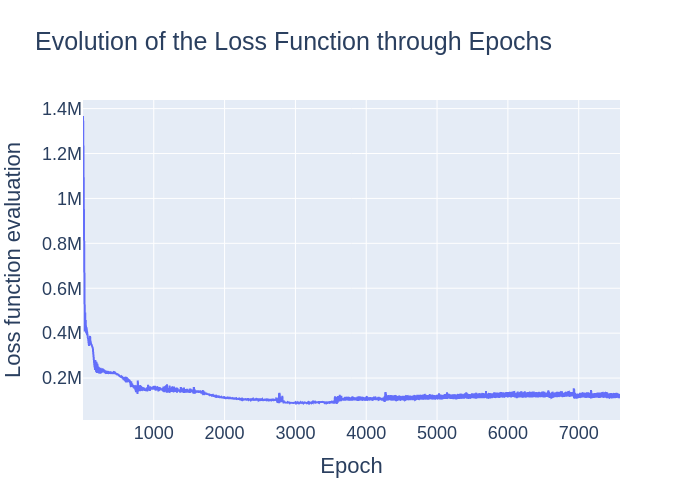

In [37]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history["Epoch"], 
    y=df_loss_history["Loss function evaluations"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the Loss Function through Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss function evaluation",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="right",
    )
)

fig.show()

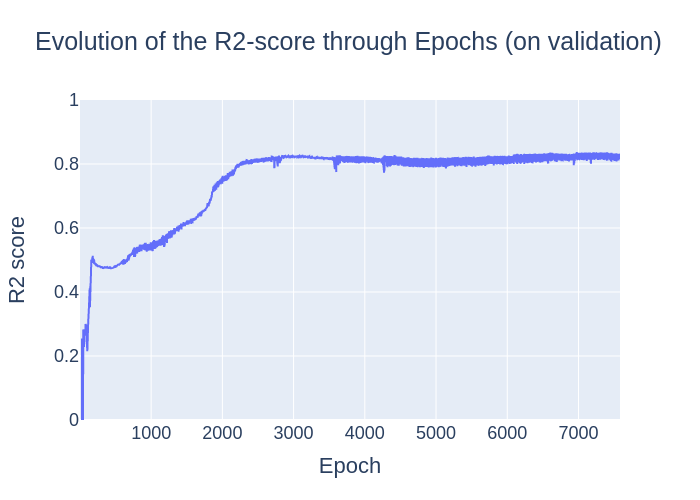

In [38]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history["Epoch"], 
    y=df_loss_history["R2 score"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the R2-score through Epochs (on validation)",
    xaxis_title="Epoch",
    yaxis_title="R2 score",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="right",
    )
)
fig.update_yaxes(range=[0.0, 1.0])

fig.show()

### MLP model setup with `sklearn`

In [39]:
regr = MLPRegressor(	
    solver='adam',
    learning_rate='adaptive',
    hidden_layer_sizes=(20, 30, 20, 10),  # 20:30:20:10 architecture
    random_state=1, 
    max_iter=max_epochs,
    tol=rel_error_stop_criterion,
    n_iter_no_change=int(min_percentage_of_num_epochs * max_epochs),
    early_stopping=True
)

In [40]:
regr.fit(X_train_rescaled, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(20, 30, 20, 10),
             learning_rate='adaptive', max_iter=20000, n_iter_no_change=4000,
             random_state=1, tol=1e-08)

In [41]:
y_predict_sklearn = regr.predict(X_test_rescaled)

dict_y_predict_sklearn = {}
for id_target, target in enumerate(list(y_train.columns)):
    dict_y_predict_sklearn[target] = y_predict_sklearn[:, id_target]
    
df_y_predict_sklearn = pd.DataFrame.from_dict(dict_y_predict_sklearn)

df_y_predict_sklearn

,deltaH0,deltaG0,S0,Cp
0,-700.496717,-603.671136,348.786828,119.696984
1,-1845.397196,-1712.931350,121.646032,132.561751
2,44.054820,67.523498,186.872483,33.517108
3,-361.017321,-334.886266,90.553502,70.667292
4,-649.253482,-608.061492,279.020027,69.711999
...,...,...,...,...
372,-417.116124,-360.722723,264.894155,62.881455
373,-1716.033181,-1550.428559,131.465979,123.083907
374,37.109694,30.884709,41.994336,15.840744
375,-515.035376,-457.395998,125.223952,93.328366


In [42]:
regr.score(X_test_rescaled, y_test)

0.8400501439684798

In [43]:
loss_evaluations_sklearn = regr.loss_curve_
df_loss_history_sklearn = pd.DataFrame.from_dict(
    {
        "Epoch": list(range(1, len(loss_evaluations_sklearn) + 1)), 
        "Loss function evaluations": loss_evaluations_sklearn
    }
)

df_loss_history_sklearn

,Epoch,Loss function evaluations
0,1,631656.910843
1,2,631554.449341
2,3,631452.845720
3,4,631341.021594
4,5,631213.788169
...,...,...
11483,11484,23854.201857
11484,11485,24137.099305
11485,11486,23618.227755
11486,11487,24305.695759


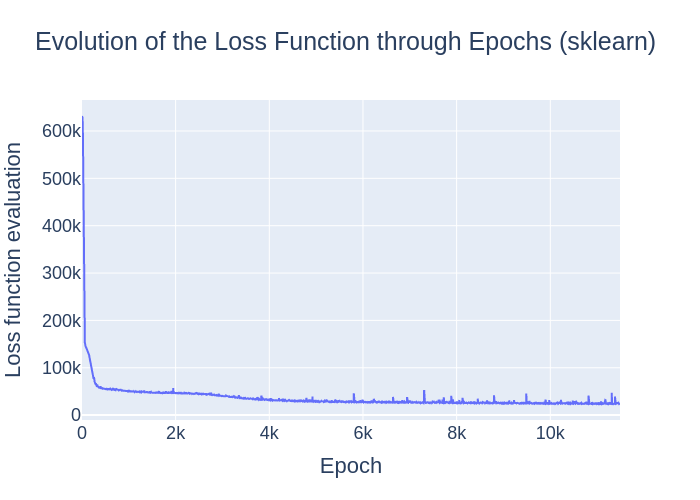

In [44]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history_sklearn["Epoch"], 
    y=df_loss_history_sklearn["Loss function evaluations"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the Loss Function through Epochs (sklearn)",
    xaxis_title="Epoch",
    yaxis_title="Loss function evaluation",
    font=dict(
        size=18,
    ),
)

fig.show()

## Assess the results

### Collecting results

In [45]:
target_errors = {}

for target_name in list(y_test.columns):
    target_abs_error = np.abs(y_test[target_name].values - df_y_predict[target_name].values)
    target_errors[f"{target_name} abs. error"] = target_abs_error
    
    target_rel_error = target_abs_error / np.abs(df_y_predict[target_name].values)
    target_errors[f"{target_name} rel. error"] = target_rel_error
    
df_target_errors = pd.DataFrame.from_dict(target_errors)
df_target_errors

,deltaH0 abs. error,deltaH0 rel. error,deltaG0 abs. error,deltaG0 rel. error,S0 abs. error,S0 rel. error,Cp abs. error,Cp rel. error
0,125.407742,4.043097,154.616487,18.154960,134.972046,0.306078,66.758594,0.444884
1,300.811108,0.148513,297.444873,0.155628,28.486680,0.199617,8.756371,0.067593
2,467.760543,24.934653,456.082410,189269.642359,27.254614,0.143820,6.471277,0.176612
3,109.923765,1.873395,96.791569,1.966971,47.796478,0.339135,1.702016,0.027479
4,23.230701,0.052502,27.084747,0.060945,11.509253,0.040227,3.477166,0.063386
...,...,...,...,...,...,...,...,...
372,261.607092,0.505807,251.594323,0.523039,24.357972,0.090830,9.032798,0.156882
373,1070.479150,0.404698,971.159941,0.403483,156.143393,7.148312,1.159471,0.009248
374,50.482403,1.000000,46.880123,1.000000,0.862156,0.021432,16.168450,2.107586
375,28.656964,0.084498,34.422800,0.132234,20.106123,0.222231,8.119632,0.132392


In [46]:
target_results = {}

for target_name in list(y_test.columns):
    target_results[f"{target_name} predicted"] = df_y_predict[target_name].values
    target_results[f"{target_name} expected"] = y_test[target_name].values
    
df_target_results= pd.DataFrame.from_dict(target_results)
df_target_results

,deltaH0 predicted,deltaH0 expected,deltaG0 predicted,deltaG0 expected,S0 predicted,S0 expected,Cp predicted,Cp expected
0,-31.017742,94.39,-8.516487,146.10,440.972046,306.00,150.058594,83.30
1,-2025.488892,-2326.30,-1911.255127,-2208.70,142.706680,114.22,129.546371,120.79
2,18.759457,486.52,-0.002410,456.08,189.505386,216.76,36.641277,30.17
3,-58.676235,-168.60,-49.208431,-146.00,140.936478,93.14,61.937984,63.64
4,-442.469299,-465.70,-444.415253,-471.50,286.109253,274.60,54.857166,51.38
...,...,...,...,...,...,...,...,...
372,-517.207092,-255.60,-481.024323,-229.43,268.172028,292.53,57.577202,66.61
373,-2645.129150,-1574.65,-2406.939941,-1435.78,-21.843393,134.30,125.379471,124.22
374,-50.482403,0.00,-46.880123,0.00,40.227844,41.09,7.671550,23.84
375,-339.143036,-367.80,-260.317200,-294.74,90.473877,110.58,61.330368,69.45


### Check `deltaH0` results

Against Molar Mass:

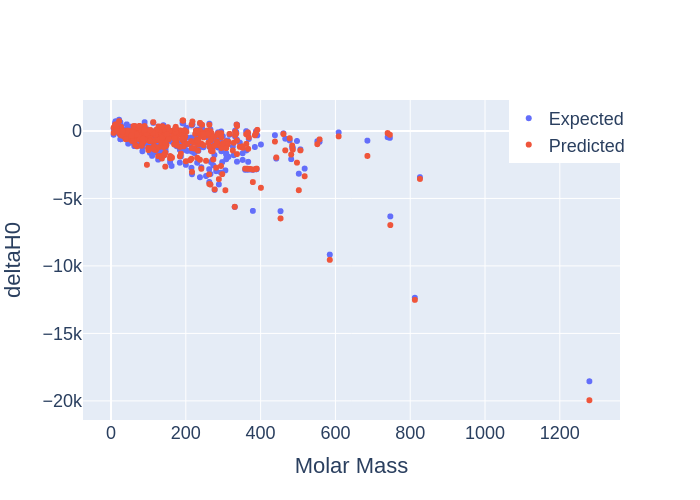

In [47]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaH0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaH0 predicted"],
    mode='markers',
    name='Predicted'
)
fig.add_traces([fig_expected, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="deltaH0",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="right",
    )
)

fig.show()

Against Expected results:

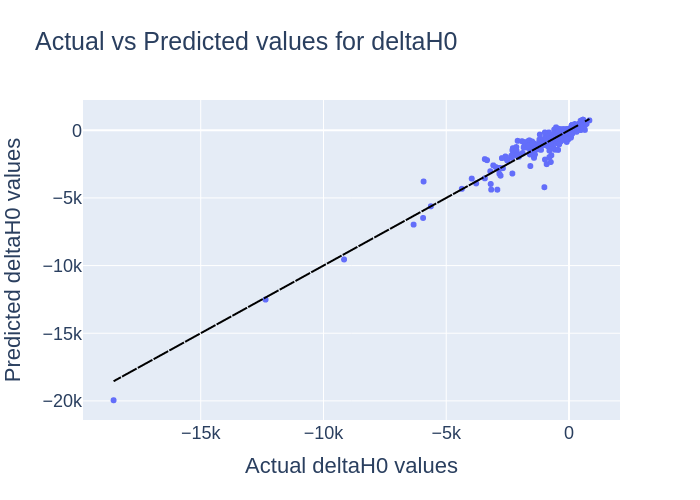

In [48]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaH0 expected"], 
    y=df_target_results["deltaH0 predicted"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaH0 expected"], 
    y=df_target_results["deltaH0 expected"],
    mode='lines',
    line=dict(color="black", dash='dash'),
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted values for deltaH0",
    xaxis_title="Actual deltaH0 values",
    yaxis_title="Predicted deltaH0 values",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

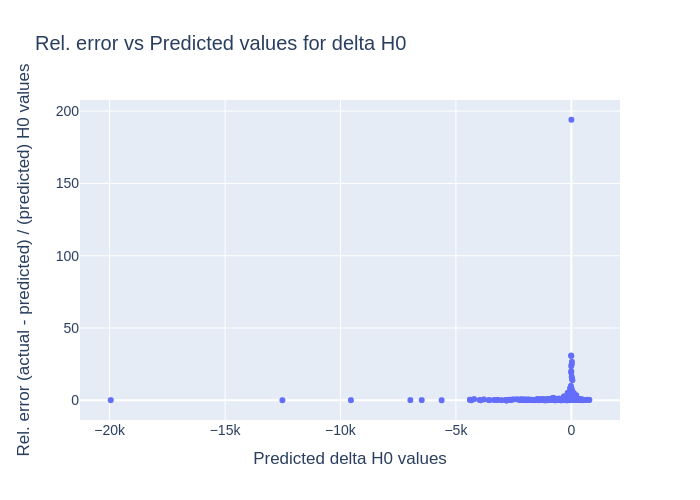

In [49]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaH0 predicted"], 
    y=df_target_errors["deltaH0 rel. error"],
    mode='markers',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Rel. error vs Predicted values for delta H0",
    xaxis_title="Predicted delta H0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) H0 values",
    showlegend=False,
    font=dict(
        size=14,
    )
)

fig.show()

`deltaH0` residuals distribution:

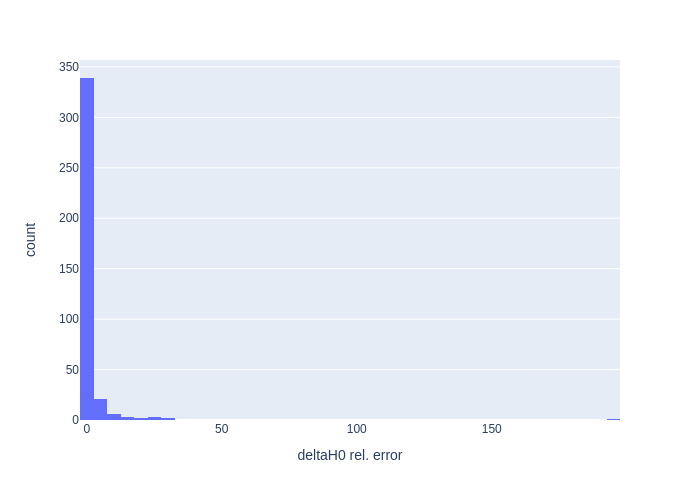

In [50]:
fig = px.histogram(df_target_errors, x="deltaH0 rel. error", nbins=80)
fig.show()

### Checking `deltaG0` results

Against molar mass:

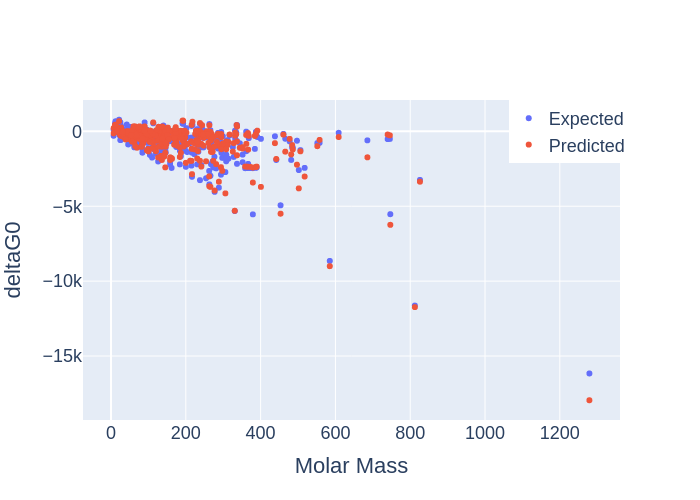

In [51]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaG0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaG0 predicted"],
    mode='markers',
    name='Predicted'
)
fig.add_traces([fig_expected, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="deltaG0",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="right",
    )
)

fig.show()

Against Expected results:

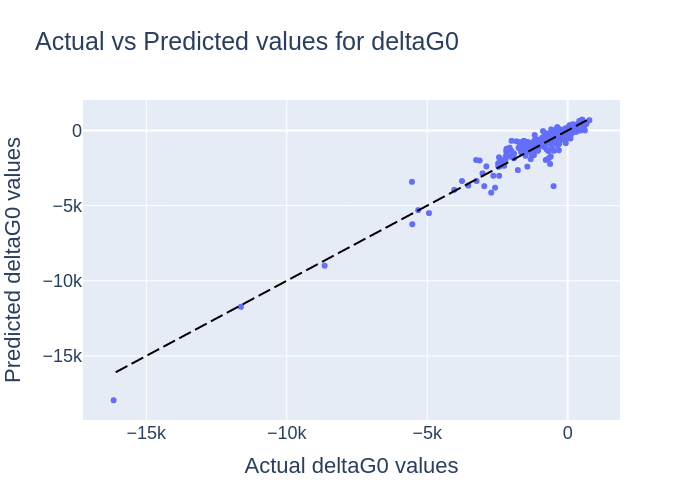

In [52]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaG0 expected"], 
    y=df_target_results["deltaG0 predicted"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaG0 expected"], 
    y=df_target_results["deltaG0 expected"],
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted values for deltaG0",
    xaxis_title="Actual deltaG0 values",
    yaxis_title="Predicted deltaG0 values",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

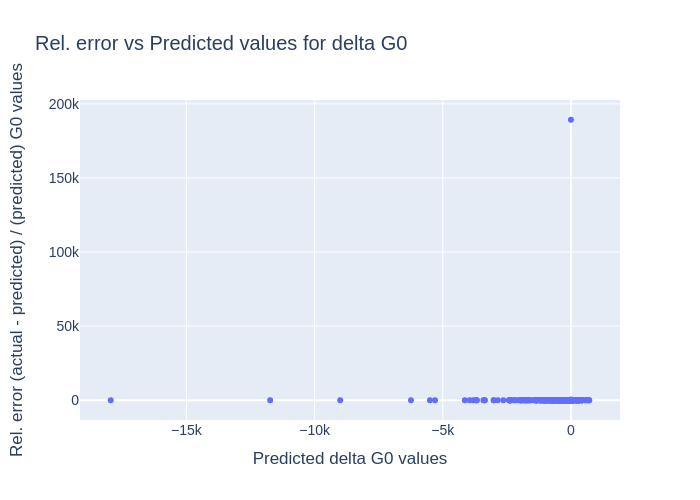

In [53]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaG0 predicted"], 
    y=df_target_errors["deltaG0 rel. error"],
    mode='markers',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Rel. error vs Predicted values for delta G0",
    xaxis_title="Predicted delta G0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) G0 values",
    showlegend=False,
    font=dict(
        size=14,
    )
)

fig.show()

`deltaG0` residuals distribution:

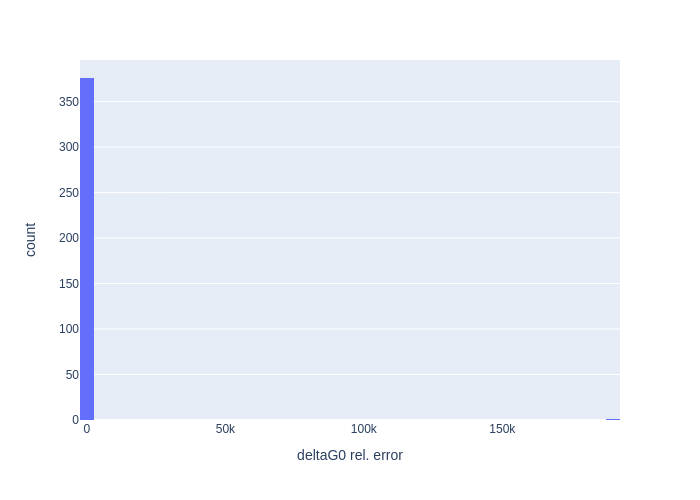

In [54]:
fig = px.histogram(df_target_errors, x="deltaG0 rel. error", nbins=80)
fig.show()

### Checking `S0` results

Checking against Molar Mass:

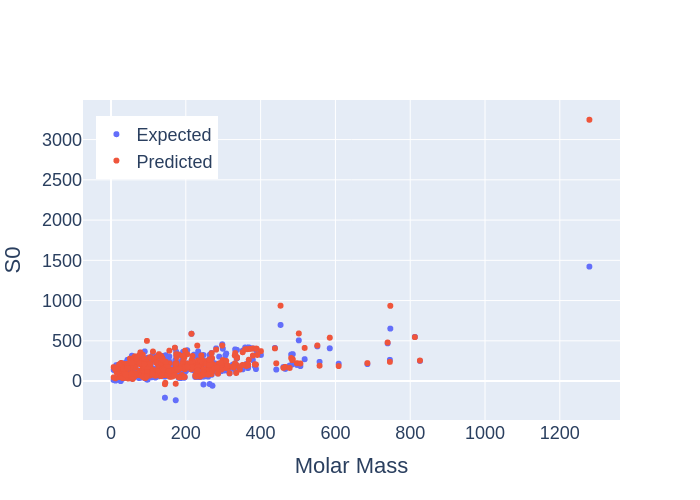

In [55]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["S0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["S0 predicted"],
    mode='markers',
    name='Predicted'
)
fig.add_traces([fig_expected, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="S0",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="left",
        x=0.025,
        y=0.95,
    )
)

fig.show()

Checking against expected results:

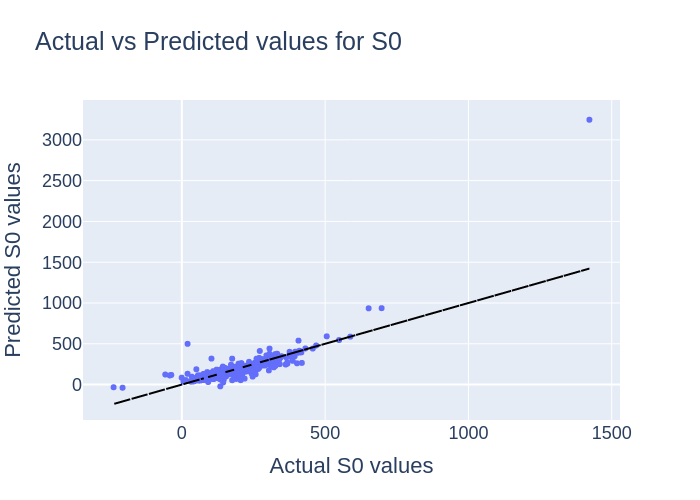

In [56]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["S0 expected"], 
    y=df_target_results["S0 predicted"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["S0 expected"], 
    y=df_target_results["S0 expected"],
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted values for S0",
    xaxis_title="Actual S0 values",
    yaxis_title="Predicted S0 values",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

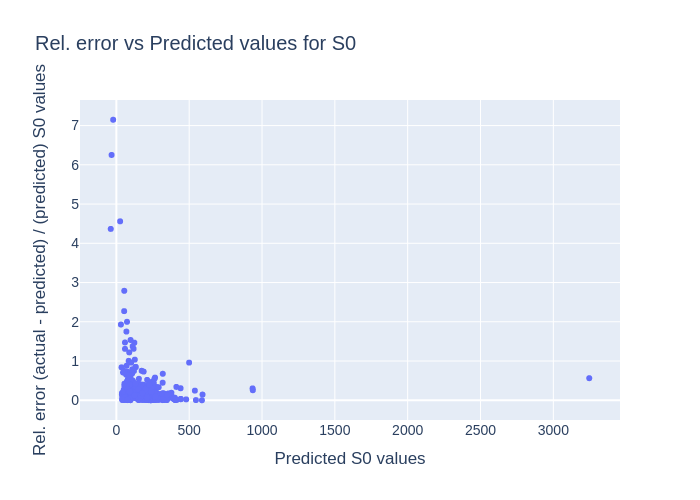

In [57]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["S0 predicted"], 
    y=df_target_errors["S0 rel. error"],
    mode='markers',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Rel. error vs Predicted values for S0",
    xaxis_title="Predicted S0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) S0 values",
    showlegend=False,
    font=dict(
        size=14,
    )
)

fig.show()

`S0` residuals distribution:

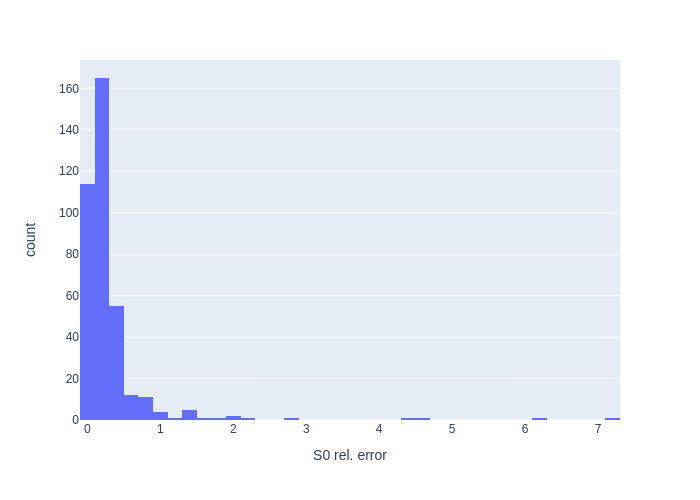

In [58]:
fig = px.histogram(df_target_errors, x="S0 rel. error")
fig.show()

### Check `Cp` results

Checking against molar mass:

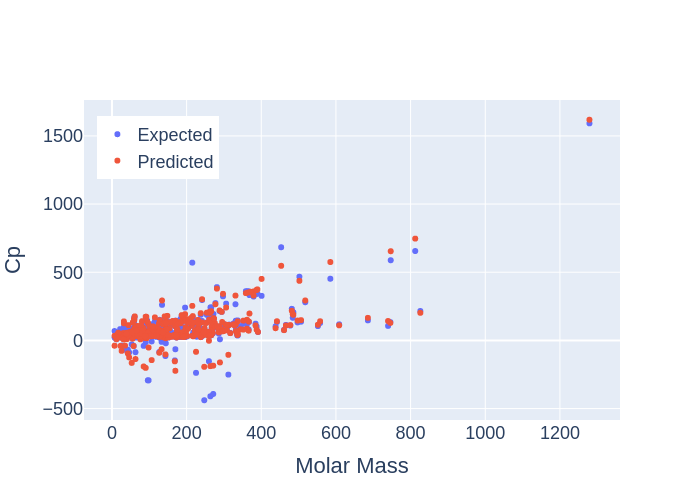

In [59]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["Cp expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["Cp predicted"],
    mode='markers',
    name='Predicted'
)
fig.add_traces([fig_expected, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="Cp",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="left",
        x=0.025,
        y=0.95,
    )
)

fig.show()

Checking against expected results:

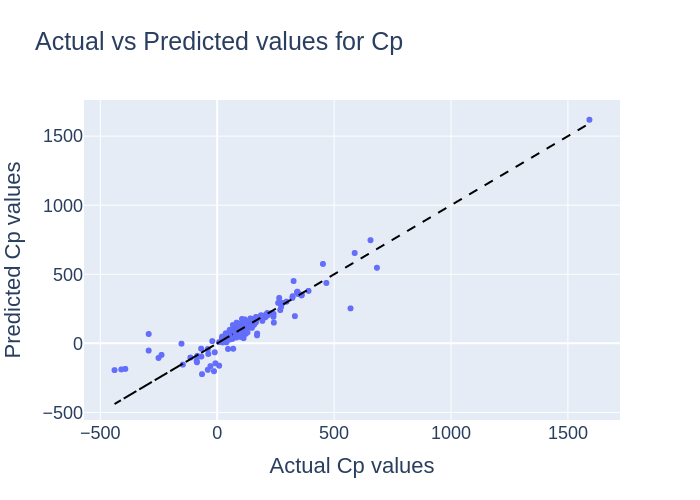

In [60]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["Cp expected"], 
    y=df_target_results["Cp predicted"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["Cp expected"], 
    y=df_target_results["Cp expected"],
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted values for Cp",
    xaxis_title="Actual Cp values",
    yaxis_title="Predicted Cp values",
    showlegend=False,
    font=dict(
        size=18,
    ),
)

fig.show()

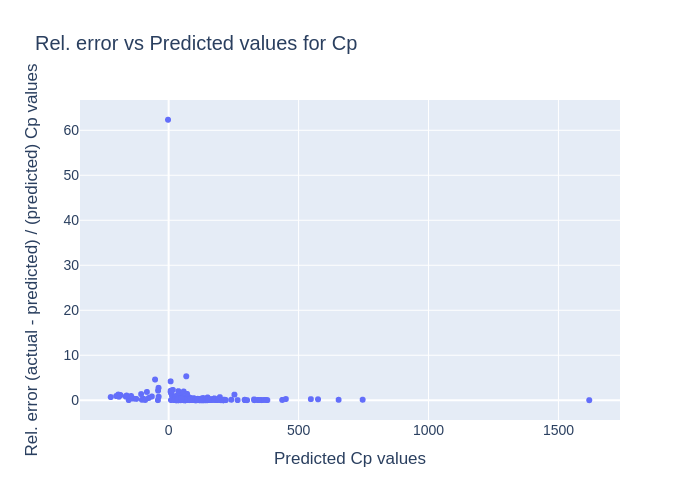

In [61]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["Cp predicted"], 
    y=df_target_errors["Cp rel. error"],
    mode='markers',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Rel. error vs Predicted values for Cp",
    xaxis_title="Predicted Cp values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) Cp values",
    showlegend=False,
    font=dict(
        size=14,
    )
)

fig.show()

`Cp` residuals distribution:

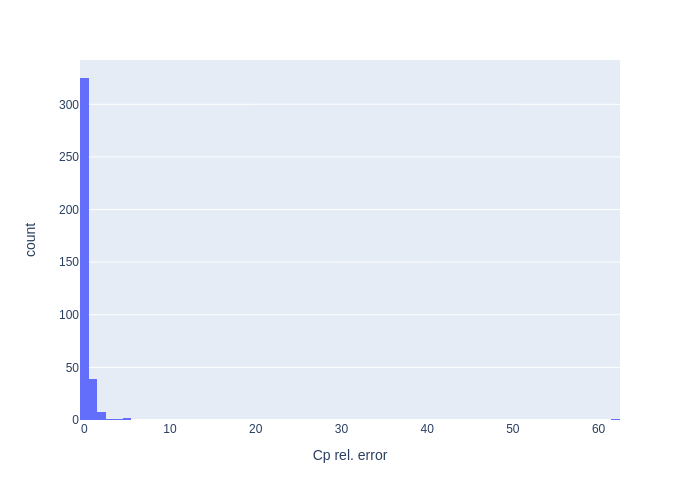

In [62]:
fig = px.histogram(df_target_errors, x="Cp rel. error", nbins=80)
fig.show()

### Verifying the consistency of the predicted values

To evaluate the quality of the predictions from a thermodynamic point of view, we should assess the GHS residual to check if the predictions are consistent.

* `skorch`

In [63]:
df_predicted_species = df_nist_stdprops.loc[X_test_rescaled.index, ["Formula", "Molar Mass", "Se"]]
for target in list(df_y_predict.columns):
    df_predicted_species.loc[:, target] = df_y_predict.loc[:, target].values
    
df_predicted_species

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp
585,Hg(CH3)2,230.6604,479.5520,-31.017742,-8.516487,440.972046,150.058594
1155,CaO·Al2O3,158.0406,508.3560,-2025.488892,-1911.255127,142.706680,129.546371
389,SiN,42.0927,114.6350,18.759457,-0.002410,189.505386,36.641277
590,Cu2O,143.0794,168.8690,-58.676235,-49.208431,140.936478,61.937984
975,UO2,270.0278,255.3480,-442.469299,-444.415253,286.109253,54.857166
...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,-517.207092,-481.024323,268.172028,57.577202
1130,CaSO4·0.5H2O,145.1493,716.7490,-2645.129150,-2406.939941,-21.843393,125.379471
162,P,30.9738,41.0900,-50.482403,-46.880123,40.227844,7.671550
1352,NaOCH3,54.0244,355.5450,-339.143036,-260.317200,90.473877,61.330368


* `sklearn`:

In [64]:
df_predicted_species_sklearn = df_nist_stdprops.loc[X_test_rescaled.index, ["Formula", "Molar Mass", "Se"]]
for target in list(df_y_predict_sklearn.columns):
    df_predicted_species_sklearn.loc[:, target] = df_y_predict_sklearn.loc[:, target].values
    
df_predicted_species_sklearn

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp
585,Hg(CH3)2,230.6604,479.5520,-700.496717,-603.671136,348.786828,119.696984
1155,CaO·Al2O3,158.0406,508.3560,-1845.397196,-1712.931350,121.646032,132.561751
389,SiN,42.0927,114.6350,44.054820,67.523498,186.872483,33.517108
590,Cu2O,143.0794,168.8690,-361.017321,-334.886266,90.553502,70.667292
975,UO2,270.0278,255.3480,-649.253482,-608.061492,279.020027,69.711999
...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,-417.116124,-360.722723,264.894155,62.881455
1130,CaSO4·0.5H2O,145.1493,716.7490,-1716.033181,-1550.428559,131.465979,123.083907
162,P,30.9738,41.0900,37.109694,30.884709,41.994336,15.840744
1352,NaOCH3,54.0244,355.5450,-515.035376,-457.395998,125.223952,93.328366


Collecting the GHS residuals:

In [65]:
T = 298.15  # in K
predicted_GHS_residuals = []
predicted_GHS_residuals_sklearn = []
expected_GHS_residuals = []
df_expected_stdprops = df_nist_stdprops.loc[X_test_rescaled.index, :]
for index, row in df_predicted_species.iterrows():
    # Skorch
    G0_predicted = row["deltaG0"] * 1000
    H0_predicted = row["deltaH0"] * 1000
    S0_predicted = row["S0"]
    Se_predicted = row["Se"]
    GHS_residual_predicted = G0_predicted - H0_predicted + T * (S0_predicted - Se_predicted)
    predicted_GHS_residuals.append(GHS_residual_predicted)
    
    # Sklearn
    G0_predicted_sklearn = df_predicted_species_sklearn.loc[index, "deltaG0"] * 1000
    H0_predicted_sklearn = df_predicted_species_sklearn.loc[index, "deltaH0"] * 1000
    S0_predicted_sklearn = df_predicted_species_sklearn.loc[index, "S0"]
    Se_predicted_sklearn = df_predicted_species_sklearn.loc[index, "Se"]
    GHS_residual_predicted_sklearn = G0_predicted_sklearn - H0_predicted_sklearn + T * (S0_predicted_sklearn - Se_predicted_sklearn)
    predicted_GHS_residuals_sklearn.append(GHS_residual_predicted_sklearn)
    
    G0_expected = df_expected_stdprops.loc[index, "deltaG0"] * 1000
    H0_expected = df_expected_stdprops.loc[index, "deltaH0"] * 1000
    S0_expected = df_expected_stdprops.loc[index, "S0"]
    Se_expected = df_expected_stdprops.loc[index, "Se"]
    GHS_residual_expected = G0_expected - H0_expected + T * (S0_expected - Se_expected)
    expected_GHS_residuals.append(GHS_residual_expected)
    
df_predicted_species["GHS residual"] = predicted_GHS_residuals
df_predicted_species_sklearn["GHS residual"] = predicted_GHS_residuals_sklearn
df_expected_stdprops["GHS residual"] = expected_GHS_residuals
df_predicted_species

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp,GHS residual
585,Hg(CH3)2,230.6604,479.5520,-31.017742,-8.516487,440.972046,150.058594,10998.641720
1155,CaO·Al2O3,158.0406,508.3560,-2025.488892,-1911.255127,142.706680,129.546371,5215.419979
389,SiN,42.0927,114.6350,18.759457,-0.002410,189.505386,36.641277,3560.739360
590,Cu2O,143.0794,168.8690,-58.676235,-49.208431,140.936478,61.937984,1139.722420
975,UO2,270.0278,255.3480,-442.469299,-444.415253,286.109253,54.857166,7225.514192
...,...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,-517.207092,-481.024323,268.172028,57.577202,2756.137976
1130,CaSO4·0.5H2O,145.1493,716.7490,-2645.129150,-2406.939941,-21.843393,125.379471,17977.886914
162,P,30.9738,41.0900,-50.482403,-46.880123,40.227844,7.671550,3345.227923
1352,NaOCH3,54.0244,355.5450,-339.143036,-260.317200,90.473877,61.330368,-205.119155


#### Visual verification

* `skorch`

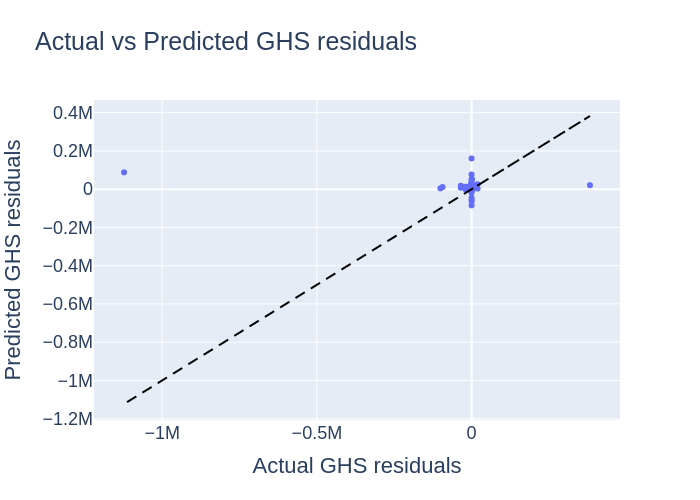

In [66]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_predicted_species["GHS residual"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_expected_stdprops["GHS residual"], 
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted GHS residuals",
    xaxis_title="Actual GHS residuals",
    yaxis_title="Predicted GHS residuals",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

* `sklearn`:

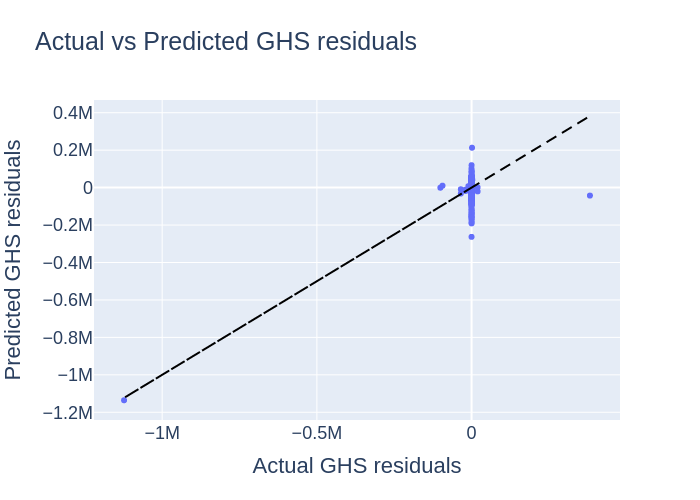

In [67]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_predicted_species_sklearn["GHS residual"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_expected_stdprops["GHS residual"], 
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted GHS residuals",
    xaxis_title="Actual GHS residuals",
    yaxis_title="Predicted GHS residuals",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

* `skorch` (consistent) vs `sklearn` (inconsistent):

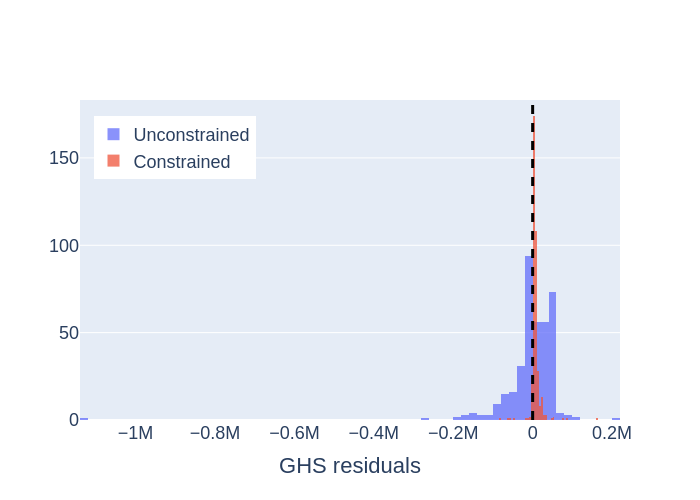

In [68]:
fig = go.Figure()

fig1 = go.Histogram(x=df_predicted_species_sklearn["GHS residual"], name='Unconstrained')
fig2 = go.Histogram(x=df_predicted_species["GHS residual"], name='Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    # title="GHS residuals",
    xaxis_title="GHS residuals",
    barmode='overlay',
    # yaxis_title="Predicted GHS residuals",
    # showlegend=False,
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="left",
        x=0.025,
        y=0.95,
    )
)
fig.update_traces(opacity=0.75)
fig.add_vline(x=0.0, line_width=3, line_dash="dash", line_color="black")

fig.show()